In [2]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
df = pd.read_csv('data/complaints.csv')
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2024-02-28,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,"EQUIFAX, INC.",UT,84124,NaN,Consent not provided,Web,2024-02-28,Closed with non-monetary relief,Yes,NaN,8440780
1,2024-06-08,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Credit inquiries on your report that you don't...,NaN,Company disputes the facts presented in the co...,Kitch Acceptance Corp.,IN,46123,Older American,Consent not provided,Web,2024-06-08,Closed with explanation,Yes,NaN,9201454
2,2024-06-07,Credit reporting or other personal consumer re...,Credit reporting,Unable to get your credit report or credit score,Other problem getting your report or credit score,NaN,NaN,Experian Information Solutions Inc.,LA,70706,NaN,NaN,Web,2024-06-07,In progress,Yes,NaN,9202734
3,2024-06-07,Debt collection,Medical debt,Written notification about debt,Didn't receive notice of right to dispute,NaN,NaN,"Paramount Recovery Systems, L.P.",FL,33401,NaN,NaN,Web,2024-06-07,Closed with explanation,Yes,NaN,9198094
4,2024-06-07,Debt collection,Other debt,Communication tactics,Frequent or repeated calls,NaN,NaN,TRANSWORLD SYSTEMS INC,MD,20784,NaN,NaN,Web,2024-06-07,Closed with explanation,Yes,NaN,9204703


In [3]:
df.isna().sum()

Date received                         0
Product                               0
Sub-product                      235295
Issue                                 6
Sub-issue                        738831
Consumer complaint narrative    3535008
Company public response         2814964
Company                               0
State                             46157
ZIP code                          30226
Tags                            4937866
Consumer consent provided?      1060402
Submitted via                         0
Date sent to company                  0
Company response to consumer         15
Timely response?                      0
Consumer disputed?              4662880
Complaint ID                          0
dtype: int64

In [4]:
df = df.dropna(subset=['Consumer complaint narrative'])

In [5]:
df.isna().sum()

Date received                         0
Product                               0
Sub-product                       52206
Issue                                 0
Sub-issue                        227900
Consumer complaint narrative          0
Company public response          896454
Company                               0
State                              6959
ZIP code                              0
Tags                            1656604
Consumer consent provided?            0
Submitted via                         0
Date sent to company                  0
Company response to consumer          6
Timely response?                      0
Consumer disputed?              1732177
Complaint ID                          0
dtype: int64

In [6]:
df.nunique()

Date received                      3360
Product                              21
Sub-product                          85
Issue                               173
Sub-issue                           266
Consumer complaint narrative    1526340
Company public response              11
Company                            6105
State                                63
ZIP code                           6933
Tags                                  3
Consumer consent provided?            1
Submitted via                         1
Date sent to company               3365
Company response to consumer          6
Timely response?                      2
Consumer disputed?                    2
Complaint ID                    1896188
dtype: int64

In [7]:
category_counts = df['Product'].value_counts()
print(category_counts)

Product
Credit reporting, credit repair services, or other personal consumer reports    807293
Credit reporting or other personal consumer reports                             268523
Debt collection                                                                 254981
Mortgage                                                                        117430
Credit card or prepaid card                                                     108669
Checking or savings account                                                      96095
Credit card                                                                      44427
Student loan                                                                     43008
Money transfer, virtual currency, or money service                               40122
Credit reporting                                                                 31587
Vehicle loan or lease                                                            31008
Payday loan, title loan, or persona

In [8]:
category_mapping = {
    'Credit reporting, credit repair services, or other personal consumer reports': 'Credit reporting',
    'Credit reporting or other personal consumer reports': 'Credit reporting',
    'Credit reporting': 'Credit reporting',
    'Debt collection': 'Debt collection',
    'Mortgage': 'Mortgage',
    'Credit card or prepaid card': 'Credit card',
    'Credit card': 'Credit card',
    'Checking or savings account': 'Checking or savings',
    'Bank account or service': 'Checking or savings',
    'Consumer Loan': 'Consumer loan',
    'Vehicle loan or lease': 'Consumer loan',
    'Payday loan, title loan, or personal loan': 'Consumer loan',
    'Payday loan, title loan, personal loan, or advance loan': 'Consumer loan',
    'Payday loan': 'Consumer loan',
    'Money transfer, virtual currency, or money service': 'Money transfer or virtual currency',
    'Money transfers': 'Money transfer or virtual currency',
    'Virtual currency': 'Money transfer or virtual currency',
    'Student loan': 'Student loan',
    'Other financial service': 'Other',
    'Debt or credit management': 'Other',
    'Prepaid card': 'Credit card'
}

In [9]:
df['Product'] = df['Product'].map(category_mapping)

In [10]:
category_counts = df['Product'].value_counts()
print(category_counts)

Product
Credit reporting                      1107403
Debt collection                        254981
Credit card                            157221
Mortgage                               117430
Checking or savings                    110980
Consumer loan                           62532
Student loan                            43008
Money transfer or virtual currency      41635
Other                                     998
Name: count, dtype: int64


In [11]:
import random
from nltk.corpus import wordnet

In [12]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [13]:
stop_words = set(stopwords.words('english'))

In [14]:
def synonym_replacement(text, n):
    words = text.split()
    new_words = words.copy()
    random_word_list = list(set([word for word in words if word not in stop_words]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if(len(synonyms) >= 1):
            synonym = random.choice(list(synonyms))
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if(num_replaced) >= n:
            break
    sentence = ' '.join(new_words)
    return sentence

In [15]:
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word): 
        for l in syn.lemmas(): 
            synonym = l.name().replace("_", " ").replace("-", " ").lower()
            synonym = "".join([char for char in synonym if char in ' abcdefghijklmnopqrstuvwxyz'])
            synonyms.add(synonym) 
    if word in synonyms: 
        synonyms.remove(word)
    return list(synonyms)

In [16]:
sample_size = 20000
balanced_data = []

In [1]:
#looping through each category to balance the data
for category in category_counts.index:
    category_data = df[df['Product'] == category]
    if len(category_data) > sample_size:
        #Undersample majority class
        category_data = category_data.sample(sample_size, random_state=42)
    elif len(category_data) < sample_size:
        augmented_data = category_data.copy()
        while len(augmented_data) < sample_size:
            for i in range(len(category_data)):
                if len(augmented_data) >= sample_size:
                    break
                augmented_text = synonym_replacement(category_data.iloc[i]['Consumer complaint narrative'], 6)
                new_row = category_data.iloc[i].copy()
                new_row['Consumer complaint narrative'] = augmented_text
                augmented_data = pd.concat([augmented_data, new_row.to_frame().T], ignore_index=True)
        category_data = augmented_data
    balanced_data.append(category_data)

NameError: name 'category_counts' is not defined

In [18]:
df_balanced = pd.concat(balanced_data, ignore_index=True)
print(df_balanced['Product'].value_counts())

Product
Credit reporting                      20000
Debt collection                       20000
Credit card                           20000
Mortgage                              20000
Checking or savings                   20000
Consumer loan                         20000
Student loan                          20000
Money transfer or virtual currency    20000
Other                                 20000
Name: count, dtype: int64


In [19]:
df_balanced.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2024-02-09,Credit reporting,Credit reporting,Problem with a company's investigation into an...,Investigation took more than 30 days,I have already sent a letter addressing the in...,NaN,"EQUIFAX, INC.",LA,70058,NaN,Consent provided,Web,2024-02-09,Closed with non-monetary relief,Yes,NaN,8318191
1,2021-07-25,Credit reporting,Credit reporting,Incorrect information on your report,Account status incorrect,"In XXXX Academic year, I was XXXX XXXX XXXX XX...",Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",NY,10305,NaN,Consent provided,Web,2021-07-25,Closed with explanation,Yes,NaN,4572785
2,2022-10-28,Credit reporting,Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,This is not a duplicate nor is this complaint ...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",CA,902XX,NaN,Consent provided,Web,2022-10-28,Closed with non-monetary relief,Yes,NaN,6135227
3,2023-10-13,Credit reporting,Credit reporting,Incorrect information on your report,Information belongs to someone else,I value your help to REMOVED a portion of the ...,NaN,"EQUIFAX, INC.",CA,XXXXX,NaN,Consent provided,Web,2023-10-13,Closed with non-monetary relief,Yes,NaN,7695304
4,2021-02-17,Credit reporting,Credit reporting,Incorrect information on your report,Account information incorrect,This account ATG Credit ( XXXX XXXX XXXX ) has...,Company believes it acted appropriately as aut...,"ATG Credit, LLC",IL,60543,NaN,Consent provided,Web,2021-02-17,Closed with explanation,Yes,NaN,4147690


In [20]:
import re
import string
from nltk.stem import WordNetLemmatizer

In [21]:
lemmatizer = WordNetLemmatizer()

In [22]:
def preprocess_text(text):
    text = text.lower()

    #remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    #remove digits
    text = re.sub(r'\d+', '', text)

    #remove stop words and lemmatize
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]

    #remove 'x's representing confidential info
    words = [word for word in words if not re.fullmatch(r'x+', word)]

    #join words back into single string
    return ' '.join(words)

In [23]:
df_balanced['Consumer complaint narrative'] = df_balanced['Consumer complaint narrative'].apply(preprocess_text)

In [24]:
df_balanced.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2024-02-09,Credit reporting,Credit reporting,Problem with a company's investigation into an...,Investigation took more than 30 days,already sent letter addressing inaccuracy unkn...,NaN,"EQUIFAX, INC.",LA,70058,NaN,Consent provided,Web,2024-02-09,Closed with non-monetary relief,Yes,NaN,8318191
1,2021-07-25,Credit reporting,Credit reporting,Incorrect information on your report,Account status incorrect,academic year proof transcript college college...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",NY,10305,NaN,Consent provided,Web,2021-07-25,Closed with explanation,Yes,NaN,4572785
2,2022-10-28,Credit reporting,Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,duplicate complaint filed third party filing c...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",CA,902XX,NaN,Consent provided,Web,2022-10-28,Closed with non-monetary relief,Yes,NaN,6135227
3,2023-10-13,Credit reporting,Credit reporting,Incorrect information on your report,Information belongs to someone else,value help removed portion data credit file ca...,NaN,"EQUIFAX, INC.",CA,XXXXX,NaN,Consent provided,Web,2023-10-13,Closed with non-monetary relief,Yes,NaN,7695304
4,2021-02-17,Credit reporting,Credit reporting,Incorrect information on your report,Account information incorrect,account atg credit dispute since atg credit fu...,Company believes it acted appropriately as aut...,"ATG Credit, LLC",IL,60543,NaN,Consent provided,Web,2021-02-17,Closed with explanation,Yes,NaN,4147690


In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [26]:
#bigrams > unigrams
tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))

In [27]:
X = tfidf_vectorizer.fit_transform(df_balanced['Consumer complaint narrative'])
y = df_balanced['Product']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [30]:
#Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

In [31]:
param_grid = {
    'C': [0.1, 1, 10],
    'max_iter': [5000, 10000]  # Increase the number of iterations
}
grid_search = GridSearchCV(
    LinearSVC(random_state=42, dual='auto'),
    param_grid,
    cv=3,  # Use fewer cross-validation folds for quicker results
    verbose=2,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3, estimator=LinearSVC(dual='auto', random_state=42), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'max_iter': [5000, 10000]},
             verbose=2)

In [32]:
print(f'Best parameters: {grid_search.best_params_}')
best_model = grid_search.best_estimator_

Best parameters: {'C': 1, 'max_iter': 5000}


In [33]:
y_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred) * 100
print(f'Accuracy after hyperparameter tuning: {accuracy:.2f}')

Accuracy after hyperparameter tuning: 83.49


In [30]:
linear_svm = LinearSVC(random_state=42, dual='auto')
linear_svm.fit(X_train, y_train)

LinearSVC(dual='auto', random_state=42)

In [31]:
y_pred = linear_svm.predict(X_test)

In [32]:
accuracy = accuracy_score(y_test, y_pred)
accuracy = accuracy*100
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 83.49


In [33]:
print('Classification Report:')
print(classification_report(y_test, y_pred))

Classification Report:
                                    precision    recall  f1-score   support

               Checking or savings       0.75      0.77      0.76      5936
                     Consumer loan       0.80      0.78      0.79      5998
                       Credit card       0.79      0.80      0.79      6008
                  Credit reporting       0.80      0.81      0.80      5875
                   Debt collection       0.77      0.77      0.77      5996
Money transfer or virtual currency       0.83      0.78      0.81      6036
                          Mortgage       0.92      0.92      0.92      6057
                             Other       0.93      0.96      0.94      6085
                      Student loan       0.93      0.91      0.92      6009

                          accuracy                           0.83     54000
                         macro avg       0.83      0.83      0.83     54000
                      weighted avg       0.83      0.83      0.

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

In [35]:
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

In [36]:
cm = confusion_matrix(y_test, y_pred)
class_names = y.unique()

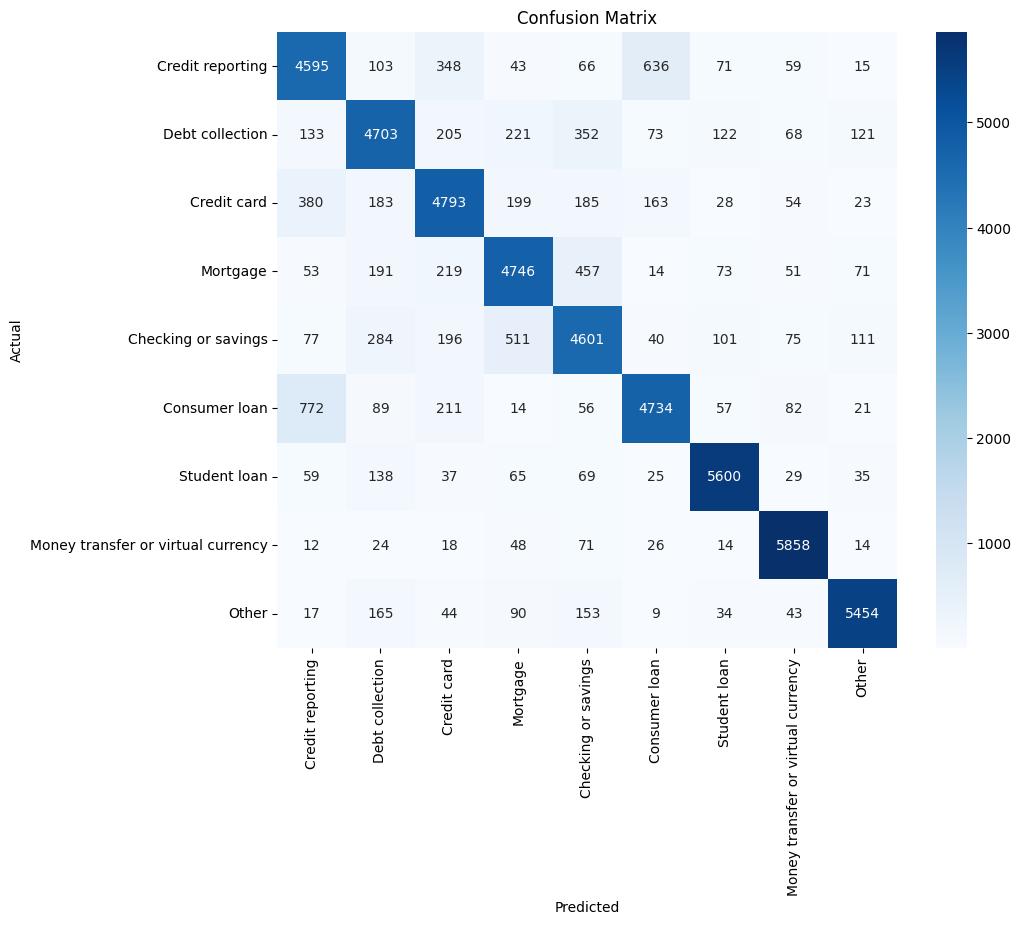

In [37]:
plot_confusion_matrix(cm, class_names)

In [38]:
def preprocess_new_complaint(complaint):
    complaint = complaint.lower()
    complaint = complaint.translate(str.maketrans('', '', string.punctuation))
    complaint = re.sub(r'\d+', '', complaint)
    words = complaint.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    words = [word for word in words if not re.fullmatch(r'x+', word)]
    return ' '.join(words)

In [39]:
new_complaint = "I was charged twice for the same transaction on my credit card and the bank is not refunding my money."
preprocessed_complaint = preprocess_new_complaint(new_complaint)
complaint_vector = tfidf_vectorizer.transform([preprocessed_complaint])
predicted_category = linear_svm.predict(complaint_vector)
print(f'The predicted category for the new complaint is: {predicted_category[0]}')

The predicted category for the new complaint is: Credit card
